# tfp on JAX tutorial

Note: I tried the tfp_on_jax with google-env and received the error
```
ImportError: cannot import name 'bijectors' from partially initialized module 'tensorflow_probability.substrates.jax' (most likely due to a circular import) (/home/ww347/.conda/envs/google-env/lib/python3.10/site-packages/tensorflow_probability/substrates/jax/__init__.py)
```
So will move on for now.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

In [2]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap

In [3]:
import jax
import tensorflow_probability as tfp
import tensorflow

2024-10-16 14:47:17.340951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 14:47:17.959273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 14:47:18.223391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 14:47:38.073136: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
# previously had 
# 0.3.25
# 2.11.0
# 0.19.0

In [5]:
print(jax.__version__)
print(tensorflow.__version__)
print(tfp.__version__)

0.4.34
2.17.0
0.24.0


Following tutorial at https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX

In [6]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [8]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[1]
num_classes = len(iris.target_names)

## Demo: Bayesian logistic regression

In [13]:
Root = tfd.JointDistributionCoroutine.Root
def model():
    w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                             sample_shape=(num_features, num_classes)))
    b = yield Root(
        tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,)))
    logits = jnp.dot(features, w) + b
    yield tfd.Independent(tfd.Categorical(logits=logits),
                          reinterpreted_batch_ndims=1)
    
dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
    return dist.log_prob(params + (labels,))

AttributeError: module 'matplotlib.pyplot' has no attribute 'slabel'

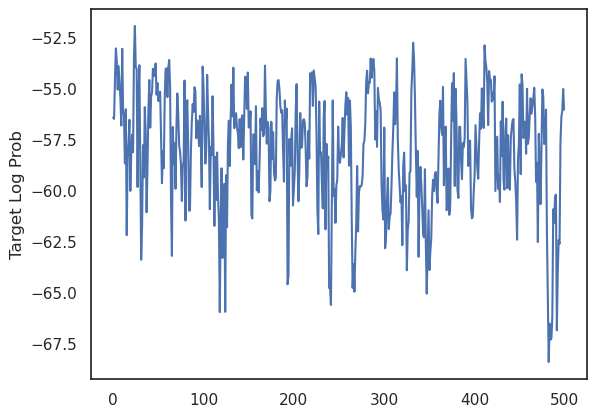

In [14]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_chain(key, state):
    kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
    return tfp.mcmc.sample_chain(500,
                                 current_state=state,
                                 kernel=kernel,
                                 trace_fn=lambda _, results: results.target_log_prob,
                                 num_burnin_steps=500,
                                 seed=key)
    
states, log_probs = run_chain(sample_key, init_params)

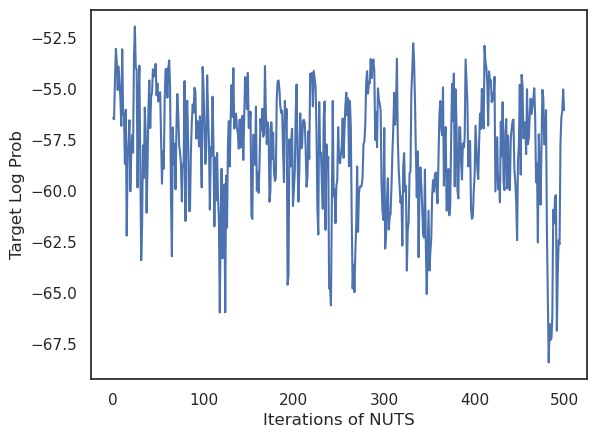

In [15]:
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

In [17]:
type(model)

function

In [19]:
instance = model()

In [22]:
dir(instance)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

Continuing with the doc page of the api
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/Distribution?_gl=1*1umy4sv*_up*MQ..*_ga*MTc5MTU1NTg3OC4xNzI5MTU3NzI1*_ga_W0YLR4190T*MTcyOTE1NzcyNS4xLjAuMTcyOTE1NzcyNS4wLjAuMA..

In [29]:
?dist.log_prob

Signature: dist.log_prob(*args, **kwargs)
Docstring:
Log probability density/mass function.


The measure methods of `JointDistribution` (`log_prob`, `prob`, etc.)
can be called either by passing a single structure of tensors or by using
named args for each part of the joint distribution state. For example,

```python
jd = tfd.JointDistributionSequential([
    tfd.Normal(0., 1.),
    lambda z: tfd.Normal(z, 1.)
], validate_args=True)
jd.dtype
# ==> [tf.float32, tf.float32]
z, x = sample = jd.sample()
# The following calling styles are all permissable and produce the exactly
# the same output.
assert (jd.log_prob(sample) ==
        jd.log_prob(value=sample) ==
        jd.log_prob(z, x) ==
        jd.log_prob(z=z, x=x) ==
        jd.log_prob(z, x=x))

# These calling possibilities also imply that one can also use `*`
# expansion, if `sample` is a sequence:
jd.log_prob(*sample)
# and similarly, if `sample` is a map, one can use `**` expansion:
jd.log_prob(**sample)
```

`JointDistribution

## Further explanation from the API
https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionCoroutine

This distribution enables both sampling and joint probability computation from a single model specification.

A joint distribution is a collection of possibly interdependent distributions. The JointDistributionCoroutine is specified by a generator that generates the elements of this collection.

The JointDistributionCoroutine is parameterized by a generator that yields tfp.distributions.Distribution-like instances.

Each element yielded implements the i-th full conditional distribution, `p(x[i] | x[:i])`. Within the generator, the return value from the yield is a sample from the distribution that may be used to construct subsequent yielded Distribution-like instances. This allows later instances to be conditional on earlier ones.


In [78]:
dist_dx = dx.JointDistributionCoroutine(model)

AttributeError: module 'distrax' has no attribute 'JointDistributionCoroutine'

In [77]:
dist.sample(seed=init_key)

StructTuple(
  var0=Array([[-0.01700382,  0.9301278 ,  0.49891132],
           [-0.4284261 ,  1.5383626 , -1.117987  ],
           [ 0.37439975,  0.01432837, -0.3702724 ],
           [ 0.91441894,  0.181802  ,  0.5114917 ]], dtype=float32),
  var1=Array([ 1.252364  ,  0.81947345, -1.2477485 ], dtype=float32),
  var2=Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)
)

In [ ]:
dist.log_prob()

In [73]:
dir(dist)

['Root',
 '_Distribution__cached_batch_shape',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_allow_nan_stats',
 '_assert_compatible_shape',
 '_batch_ndims',
 '_batch_shape',
 '_batch_shape_parts',
 '_batch_shape_tensor',
 '_batch_shape_tensor_parts',
 '_broadcast_parameters_with_batch_shape',
 '_cached_event_shape',
 '_cached_static_attributes',
 '_call_cdf',
 '_call_execute_model',
 '_call_flat_sample_distributions',
 '_call_log_cdf',
 '_call_log_prob',
 '_call_log_survival_function',
 '_call_prob',
 '_call_quantile',
 '_call_sample_and_log_prob',
 '_call_sample_n'

# From tfp user guide
https://www.tensorflow.org/probability/examples/TensorFlow_Distributions_Tutorial?_gl=1*zu0sww*_up*MQ..*_ga*MTc5MTU1NTg3OC4xNzI5MTU3NzI1*_ga_W0YLR4190T*MTcyOTE1NzcyNS4xLjAuMTcyOTE1ODIzMS4wLjAuMA..

In [38]:
import distrax as dx

In [32]:
from jax import random as r

In [34]:
orig_key = r.key(seed=42)
def key_from_string(desc_str: str):
    return r.fold_in(orig_key, hash(desc_str))

In [50]:
n = tfd.Normal(loc=0., scale=1.)
print(n)
n.sample(seed=key_from_string('n1'))
# somewhat confusingly, the argument seed must be a PRNGKey

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


Array(2.3694248, dtype=float32)

In [51]:
n.sample(3, seed=key_from_string('3 normals'))

Array([-0.49219024,  1.2733735 ,  0.4456583 ], dtype=float32)

In [52]:
n.log_prob(0.)

Array(-0.9189385, dtype=float32)

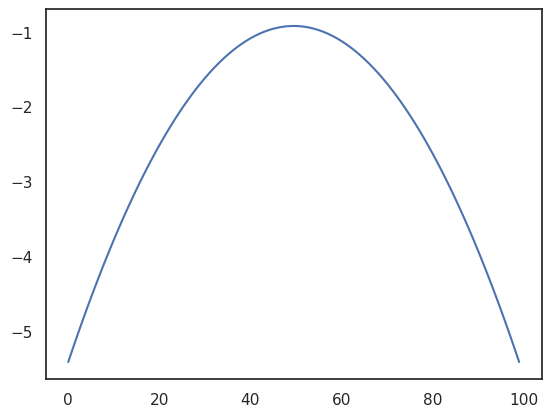

In [53]:
plt.plot(n.log_prob(jnp.linspace(-3., 3., 100)))

In [55]:
b = tfd.Bernoulli(probs=0.7)
print(b)
print(b.sample(seed=key_from_string('b1')))
print(b.sample(10, seed=key_from_string('10 bernoullis')))

tfp.distributions.Bernoulli("Bernoulli", batch_shape=[], event_shape=[], dtype=int32)
0
[1 1 1 1 1 1 1 0 0 1]


### Multivariate

In [59]:
nd = tfd.MultivariateNormalDiag(loc=[0., 10.], scale_diag=[1,4])
print(nd)
nd.sample(5, seed=key_from_string('5 mvn'))

tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[], event_shape=[2], dtype=float32)


Array([[-0.9116098 ,  7.8647423 ],
       [-1.8258168 , 13.42579   ],
       [ 0.04929734, 10.511672  ],
       [-0.4303508 , 11.182963  ],
       [ 0.9350326 , 14.898373  ]], dtype=float32)

What is the difference? `event_shape`

Note returned sample is shape(5,2) and therefore the different samples are in the 'first' index of the shape

Shape of data: (200, 2)


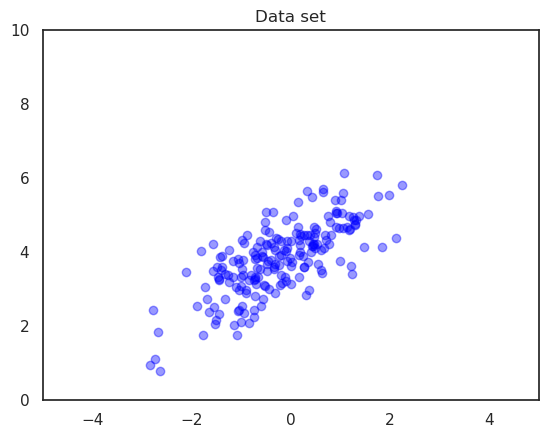

In [64]:
covariance_matrix = jnp.array([[1., .7], [.7, 1.]])
nd  = tfd.MultivariateNormalTriL(
    loc = [0., 4.], scale_tril = jnp.linalg.cholesky(covariance_matrix)
)
data = nd.sample(200, seed=key_from_string('200 mvn'))
print(f"Shape of data: {data.shape}")
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.4)
plt.axis([-5, 5, 0, 10])
plt.title("Data set")
plt.show()

In [ ]:
tfd

In [65]:
nds = tfd.MultivariateNormalDiag(loc=[[0., 10.], [0., 5.], [0., 1.]], scale_diag=[1,4])

In [66]:
nds

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

In [68]:
out = nds.sample(4, seed=key_from_string('4 mvn'))
print(out)
print(out.shape)

[[[ 0.5161871   9.023041  ]
  [-0.02643514 -2.3144598 ]
  [ 0.88242334  1.5117736 ]]

 [[ 0.08827829  7.7355285 ]
  [-1.7543819   5.221479  ]
  [-1.2358396   3.9163895 ]]

 [[ 0.13290206  9.384385  ]
  [-1.1976161   4.4402437 ]
  [ 0.30586538  1.3759463 ]]

 [[ 1.5396901  11.990859  ]
  [-0.47695354  2.5293107 ]
  [ 0.6888058  -1.3550718 ]]]
(4, 3, 2)


Conclude the ordering of the axes is: num_samples, batch_shape, event_shape

### Independent: aggregates batches to events

In [69]:
b3 = tfd.Bernoulli(probs=[0.7, 0.3, 0.5])
b3_joint = tfd.Independent(b3, reinterpreted_batch_ndims=1)
b3_joint

<tfp.distributions.Independent 'IndependentBernoulli' batch_shape=[] event_shape=[3] dtype=int32>

In [72]:
print(b3.prob([1, 1, 0]))
print(b3_joint.prob([1,1,0]))

[0.7 0.3 0.5]
0.105000004


Some further notes:

- event_shape, batch_shape and sample_shape can be arbitrary rank (in this tutorial they are always either scalar or rank 1). This increases the power but again can lead to programming challenges, especially when broadcasting is involved. For an additional deep dive into shape manipulation, see the Understanding TensorFlow Distributions Shapes.
- TFP includes a powerful abstraction known as Bijectors, which in conjunction with TransformedDistribution, yields a flexible, compositional way to easily create new distributions that are invertible transformations of existing distributions. We'll try to write a tutorial on this soon, but in the meantime, check out the documentation

# Personal exercise

Learning the mean of a 1D distribution.
Will use a proper scoring rule and take gradients